In [2]:
from src.datasets.crack_loader import CrackLoader
from torchvision import models
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from utils import set_seed
import os
from torchvision import datasets, transforms
from src.nets.lenet import LeNet5
import seaborn as sns
from src.nets.swag import SWAG
import torch
from sklearn.calibration import calibration_curve

DATA_DIR = './data/crack'

set_seed(0)

In [101]:
def compute_uncertainties(probs, eps = 1e-12):
    # T: num MC passes
    # B: batch size
    # C: num classes

    T = probs.shape[0]
    probs = np.clip(probs, eps, 1 - eps)

    probs_mean = np.mean(probs, axis=0) # (B, C) 
    
    total_unc = -np.sum(probs_mean * np.log(probs_mean + eps), axis=1) # (B,) 
    ale_unc = np.mean(-np.sum(probs * np.log(probs + eps), axis=2), axis=0) # (B,)
    epi_unc = total_unc - ale_unc

    return total_unc, ale_unc, epi_unc

def total_uncertainty(out_probs, eps=1e-12):
    # out_probs shape: [M x N x 2]
    # M: num models
    # N: num samples
    # 2: num classes

    # TU = H(p_mean(y)), p_mean(y): average predictive probabilities over M models

    pmean = np.mean(out_probs, axis=0) # N x 2
    return -np.sum(pmean * np.log(pmean + eps), axis=1) # N

def aleatoric_uncertainty(out_probs, eps=1e-12):
    # out_probs shape: [M x N x 2]
    # M: num models
    # N: num samples
    # 2: num classes

    # AU = mean(H(p_m(y))), p_m(y): predictive probabilities for model m

    entropy_pm = -np.sum(out_probs * np.log(out_probs + eps), axis=-1) # M x N
    return np.mean(entropy_pm, axis=0) # N

def thresholded_accuracy(output_probs):
    output_probs_max_val = np.max(output_probs, axis=-1)  # M x N
    output_probs_max_class = np.argmax(output_probs, axis=-1)  # M x N
    
    tr = np.linspace(0, 1, 10)
    M, N, _ = output_probs.shape
    accuracies = np.zeros((len(tr), M))
    num_labels = np.zeros((len(tr), M))
    
    for i, threshold in enumerate(tr):
        for m in range(M):
            # Get boolean mask for samples with probability > threshold
            mask = output_probs_max_val[m] < threshold  # N 
    
            # Mask predictions
            valid_preds = output_probs_max_class[m][mask] 
            valid_labels = true_labels[mask]
    
            # Compute accuracy for valid predictions
            if len(valid_labels) > 0:
                accuracies[i, m] = np.mean(valid_preds == valid_labels)
            else:
                accuracies[i, m] = np.nan
            num_labels[i, m] = len(valid_labels)
    
    accuracies_avg_models = np.mean(accuracies, axis=1)
    num_labels_avg_models = np.mean(num_labels, axis=1)
    
    sns.lineplot(x=tr, y=accuracies_avg_models, marker='o', label='Accuracy')
    sns.lineplot(x=tr, y=tr, marker='o', label='Calibrated model')
    plt.xlabel(r'Confidence threshold $\tau$')
    plt.ylabel(r'Accuracy on examples p(y|x) >= $\tau$')
    plt.grid(True)
    plt.show()

def nll(probabilities, labels, eps=1e-6):
    score = -np.log(probabilities+eps)[range(labels.shape[0]), labels].mean()
    return score
    
def accuracy(probabilities, labels):
    predicted = np.argmax(probabilities, axis=-1)
    return np.sum(labels == predicted) / len(labels)

def brier_score(probabilities, labels):
    num_classes = probabilities.shape[1]

    targets_one_hot = np.zeros_like(probabilities)
    targets_one_hot[np.arange(labels.shape[0]), labels] = 1.

    squared_diff = (targets_one_hot - probabilities) ** 2
    score = np.mean(np.sum(squared_diff, axis=1) / num_classes)

    return score
    
def compute_ece(probs, labels, num_bins=10):
    predictions = np.argmax(probs, axis=-1)
    ece = 0.0
    bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
    
    for i in range(num_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = (predictions > bin_lower) & (predictions <= bin_upper)
        bin_size = np.sum(in_bin)
        
        if bin_size > 0:
            avg_confidence = np.mean(predictions[in_bin])
            avg_accuracy = np.mean(labels[in_bin])
            ece += (bin_size / len(predictions)) * np.abs(avg_confidence - avg_accuracy)
            
    return ece.item()

def plot_calibration(probs, labels, n_bins=10):
    confidences = np.max(probs, axis=-1)
    predictions = np.argmax(probs, axis=-1)

    fraction_of_positives, mean_confidences = calibration_curve(
        (predictions == labels), confidences, n_bins=n_bins
    )
    
    plt.plot(mean_confidences, fraction_of_positives, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.title('Reliability Diagram')
    plt.xlabel('Confidence')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.grid()
    plt.show()

def plot_images_uncertainty(probs, tu, au, eu, max_unc=True):
    if max_unc:
        tu_indices = np.argsort(tu)[-4:]
        tu_values = tu[tu_indices]
    else:
        tu_indices = np.argsort(tu)[:4]
        tu_values = tu[tu_indices]
        
    predicted_classes = np.argmax(probs, axis=-1)
    class_0_count = np.sum(predicted_classes == 0, axis=0) 
    class_1_count = np.sum(predicted_classes == 1, axis=0)
    fig, axes = plt.subplots(1, len(tu_indices), figsize=(10, 3))
    for ax, idx in zip(axes, tu_indices):
        image, label = val_dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()
        ax.imshow(image_np)
        ax.axis('off')
        ax.set_title(f"({idx})\nLabel: {label}\ntu = {tu[idx]:.3f}\nau = {au[idx]:.3f}\neu = {eu[idx]:.3f}\nPredicted 0/1:\n {class_0_count[idx]}/{class_1_count[idx]}")
    plt.tight_layout()
    plt.show()

def plot_images_wrong(probs, labels, tu, au, eu):
    mean_predictions = np.argmax(np.mean(output_probs, axis=0), axis=-1)
    wrong_indices = np.where(mean_predictions != results['true_labels'])[0][:4]
    fig, axes = plt.subplots(1, len(wrong_indices), figsize=(10, 3))
    for ax, idx in zip(axes, wrong_indices):
        image, label = val_dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()
        ax.imshow(image_np)
        ax.axis('off')
        ax.set_title(f"({idx})\nLabel: {get_label(label)}\nPredicted: {get_label(mean_predictions[idx])}\ntu = {tu[idx]:.3f}\nau = {au[idx]:.3f}\neu = {eu[idx]:.3f}")
    plt.tight_layout()
    plt.show()

def get_label(label):
    return 'cracked' if label==0 else 'uncracked'

## Dataset inspection
This assignment is on image classification problem using deep convolutional neural networks. The dataset consists of images obtained from concrete bridge decks, pavements, and walls. The images can contain either cracks or no cracks. Your objective in this challenge is to develop a binary image classification model that can classify from a given image if it contains any cracks or not.

We load the data accordingly and the corresponding labels will be:
- $0$: *cracked*
- $1$: *uncracked*

The dataset consists of $14968$ observations:
- $7501$ belonging to *cracked* class and
- $7467$ belonging to *uncracked* class

We perform a static split of the data:

- 80% of the dataset ($11974$ samples) for training and 20% for validation ($2994$)

We proceed with visualizing some samples from the un-normalized dataset:

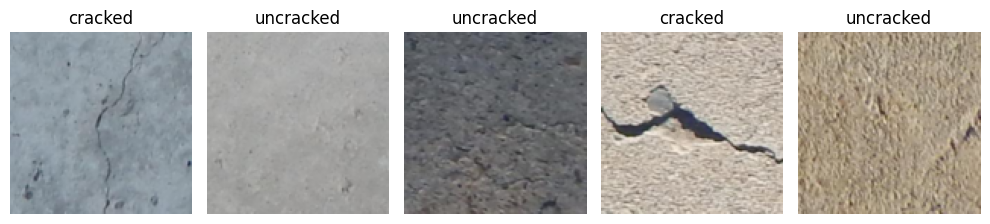

In [85]:
# TODO say we use 120x120 crop
results = np.load('./experiments/results/resnet18_vi.npz')
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor()
])
train_image_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=transform)
train_dataset = torch.utils.data.Subset(train_image_dataset, results['train_indices'])
val_dataset = torch.utils.data.Subset(train_image_dataset, results['val_indices'])
indices = [0, 10, 60, 80, 100]
fig, axes = plt.subplots(1, len(indices), figsize=(10, 5))
for ax, idx in zip(axes, indices):
    image, label = val_dataset[idx]
    image_np = image.permute(1, 2, 0).numpy()
    ax.imshow(image_np)
    ax.axis('off')
    ax.set_title(f"{get_label(label)}")
        
plt.tight_layout()
plt.show()

## Pre-trained ResNet18 and optimization

The model used for this and subsequent steps is a pre-trained ResNet18, originally trained on the ImageNet dataset. After exploring several alternatives, this approach proved to be the most promising.

**Transfer learning**: For this kind of problems the pre-training resulted to be really effective compared to a training for scratch of the model. This can be explained by the fact that the pre-trained model has already learnt general features like edges, textures and patterns that are transferable to crack detection. Pre-trained models have a robust initial weight configuration, which helps avoid overfitting, especially when the crack detection dataset is small or imbalanced

Training setting:
- Optimizer: SGD
    - Starting learning rate: $0.01$
    - Momentum: $0.9$
    - Weight decay: $1e-4$
- Scheduler: CosineAnnealingLR
- Epochs: $30$

Note: that this setup will remain unchanged also for the approximate Bayesian inference

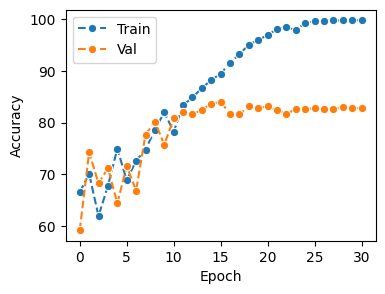

Validation accuracy: 82.832%
Validation MNLL: 0.959


In [86]:
results = np.load('./experiments/results/resnet18_optim.npz')
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.lineplot(results['train_accuracy_progress'], label='Train', marker='o', linestyle='--', ax=ax)
sns.lineplot(results['valid_accuracy_progress'], label='Val', marker='o', linestyle='--', ax=ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.show()
acc = accuracy(results['predictions'], results['true_labels'])
neg_loglik = nll(results['predictions'], results['true_labels'])
print(f"Validation accuracy: {acc*100:.3f}%")
print(f"Validation MNLL: {neg_loglik:.3f}")

## Monte Carlo dropout

Next, we analyze the performance of Monte Carlo dropout, a widely used technique for estimating uncertainty in deep learning models. In practice, this method involves keeping dropout layers active during test time. Dropout is a regularization technique that is particularly effective when training over-parameterized models. 

Setup:

- After loading the pre-trained ResNet18 model we include a dropout layer after each Conv2D unit within each residual block.
- Dropout probability: $p=0.2$ meaning that during training (and testing) the units will be set to $0$ with probability $Bernoulli(0.2)$
- We collect $50$ Monte Carlo samples at the end of training

Validation Accuracy: 84.636%
Validation MNLL: 0.415
TU = 0.2208 +- 0.2441
AU = 0.1762 +- 0.1963
EU = 0.0446 +- 0.0634
ECE = 0.0888


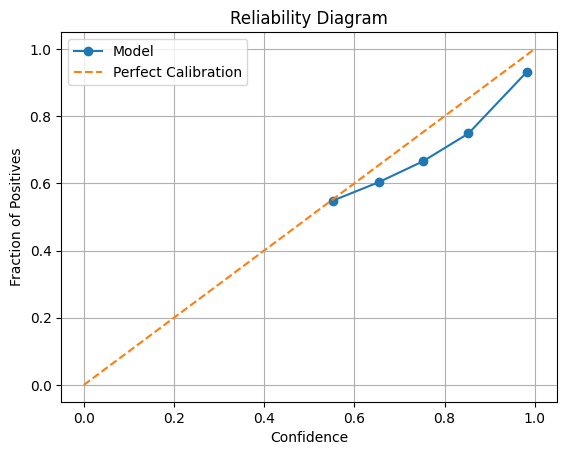

In [102]:
results = np.load('./experiments/results/resnet18_mcdropout.npz')
output_probs = results['predictions']
true_labels = results['true_labels']
tu = total_uncertainty(output_probs)
au = aleatoric_uncertainty(output_probs)
eu = tu - au
ece = compute_ece(np.mean(output_probs, axis=0), true_labels)
acc = accuracy(np.mean(output_probs, axis=0), results['true_labels'])
mnll = nll(np.mean(output_probs, axis=0), results['true_labels'])
print(f"Validation Accuracy: {acc*100:.3f}%")
print(f"Validation MNLL: {mnll:.3f}")
print("TU = {:.4f} +- {:.4f}".format(np.mean(tu), np.std(tu)))
print("AU = {:.4f} +- {:.4f}".format(np.mean(au), np.std(au)))
print("EU = {:.4f} +- {:.4f}".format(np.mean(eu), np.std(eu)))
print("ECE = {:.4f}".format(ece))
plot_calibration(output_probs.mean(0), true_labels)

- The mean Total Uncertainty ($0.2208$) indicates moderate uncertainty across the dataset. The relatively high standard deviation ($0.2441$) shows that the model's confidence fluctuates significantly across different inputs.
- A significant portion of the total uncertainty comes from aleatoric uncertainty, reflecting inherent data noise or class overlap.
- The relatively low mean Epistemic Uncertainty ($0.0446$) indicates that the model is confident in its predictions for most inputs.
- From the reliability diagram we notice that the model exhibits a slighlty over-conifident behaviour.

Here are $4$ crack images for which the classifier is the most **unsure** about (considering only the Total Uncertainty):

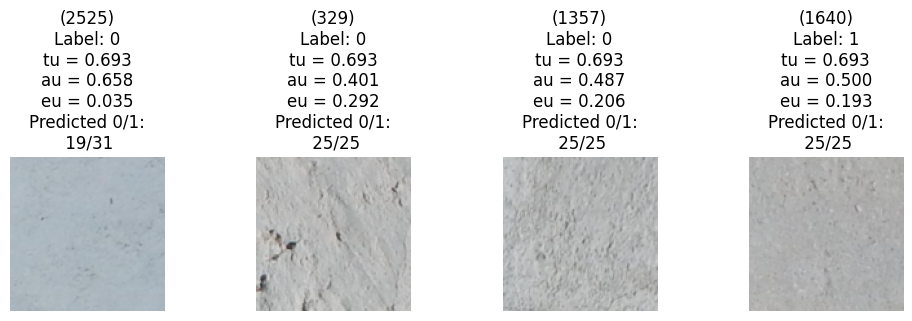

In [106]:
plot_images_uncertainty(output_probs, tu, au, eu, max_unc=True)
# TODO comment on what is reported on the images

Here are $4$ crack images for which the classifier is the most **sure** about:

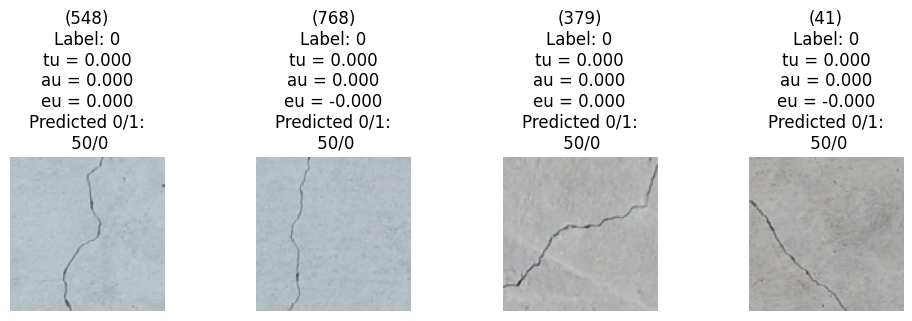

In [104]:
plot_images_uncertainty(output_probs, tu, au, eu, max_unc=False)

Here are $4$ crack images for which the classifier is wrong (considering an average of the predictive probabilties coming from each MC sample):

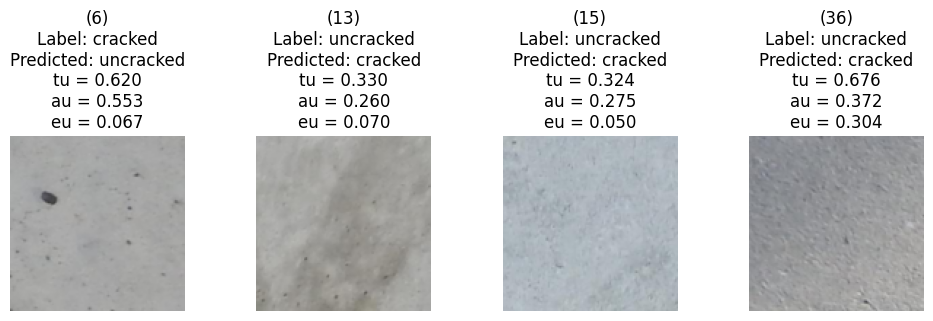

In [105]:
plot_images_wrong(output_probs, results['true_labels'], tu, au, eu)

## Variational Inference

To implement Variational Inference we still considered the same pre-trained ResNet18 model adding a final **bayesian** layer:
- The final Bayesian layer implements a Bayesian fully connected layer, which introduces uncertainty into the model's parameters. This is done by modeling the weights with a distribution rather than fixed values.
- The `forward` method of the PyTorch model uses the *reparameterization trick*, where the weight matrix is sampled from a Gaussian distribution with a mean (mu) and standard deviation (sigma) parametrized by learnable parameters. This enables backpropagation through the random sampling process. The forward pass computes the weights as $\mu$ + $\sigma$ * $\epsilon$, where $\epsilon$ is sampled from a standard normal distribution. This allows for gradient-based optimization while still maintaining a probabilistic framework.
- A $\mathcal{N}(0, 1)$ prior is assumed for the weight distribution. The initialization of the variance played an important role
- We initialized $\sigma ≈ 0.135$: This is choice has been made to ensure that the model does not start off with too large uncertainty, which was leading to poor early-stage learning.

Validation Accuracy: 78.991%
Validation MNLL: 0.449
TU = 0.3753 +- 0.2260
AU = 0.3655 +- 0.2287
EU = 0.0098 +- 0.0189
ECE = 0.1546


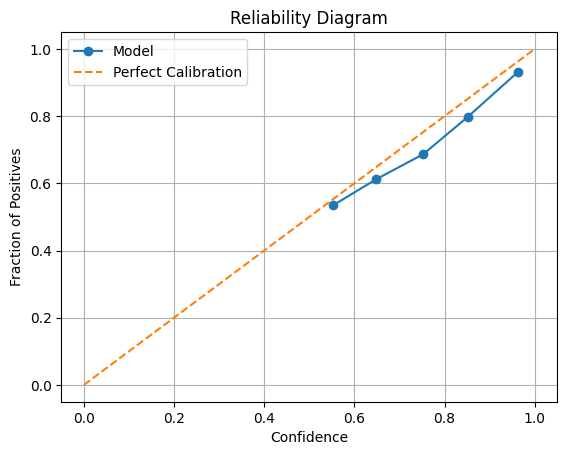

In [115]:
results = np.load('./experiments/results/resnet18_vi.npz')
output_probs = results['predictions']
true_labels = results['true_labels']
tu = total_uncertainty(output_probs)
au = aleatoric_uncertainty(output_probs)
eu = tu - au
ece = compute_ece(np.mean(output_probs, axis=0), true_labels)
acc = accuracy(np.mean(output_probs, axis=0), results['true_labels'])
mnll = nll(np.mean(output_probs, axis=0), results['true_labels'])
print(f"Validation Accuracy: {acc*100:.3f}%")
print(f"Validation MNLL: {mnll:.3f}")
print("TU = {:.4f} +- {:.4f}".format(np.mean(tu), np.std(tu)))
print("AU = {:.4f} +- {:.4f}".format(np.mean(au), np.std(au)))
print("EU = {:.4f} +- {:.4f}".format(np.mean(eu), np.std(eu)))
print("ECE = {:.4f}".format(ece))
plot_calibration(output_probs.mean(0), true_labels)

Here are $4$ crack images for which the classifier is the most **unsure** about:

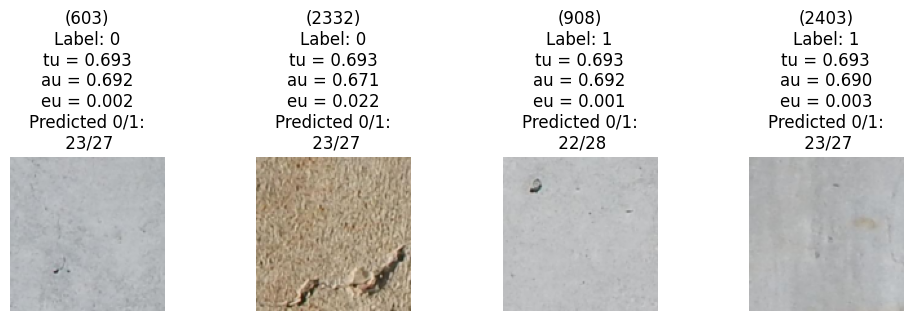

In [116]:
plot_images_uncertainty(output_probs, tu, au, eu, max_unc=True)

Here are $4$ crack images for which the classifier is the most **sure** about:

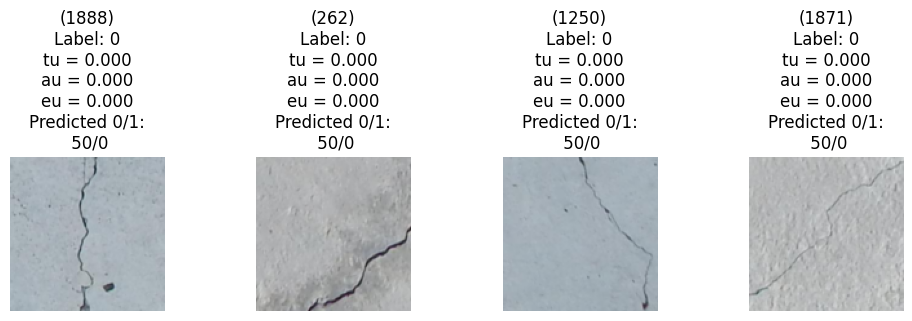

In [117]:
plot_images_uncertainty(output_probs, tu, au, eu, max_unc=False)

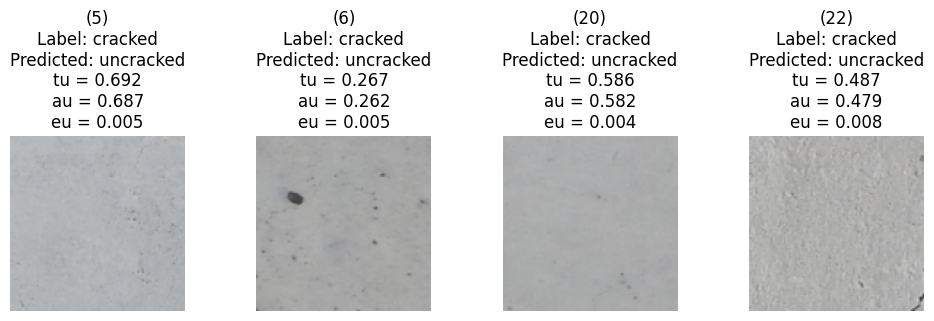

In [118]:
plot_images_wrong(output_probs, results['true_labels'], tu, au, eu)